%md
<div class="alert alert-block alert-info">
<center> <h1> Cusotmer Segmentation and Sales Forecast</h1> </center> <br>
<center> Big Data Analytics 2025</center><br>
<center> NOVA IMS MDSAA</center>

### [NOTE]
In this project, we are going to work on 3 notebooks:
- 1. Cleaning: For EDA and Data Preprocessing
- 2. Clustering: For clustering 
- 3. Project Forecasting: For Sales Forecast.<br>
##### **This notebook is 2. Clustering.**

%md
# Group 77

|   | Student Name          |  Student ID | 
|---|-----------------------|    ---      |
| 1 | Hassan Bhatti       |  20241022 |
| 2 | Moeko Mitani          |   20240670  | 
| 3 | Oumayma Ben Hfaiedh   |   20240699  | 
| 4 | Ricardo Pereira      |  20240745  | 

# 1. Data Integration 

## Import Libraries

In [0]:
# ─────────────────────────────────────────────
# Spark Core
# ─────────────────────────────────────────────
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import (
    col, lit, to_timestamp, to_date, year, month, dayofmonth,
    count, countDistinct, sum, avg, min, max,
    round, when, datediff, current_date, concat_ws,
    monotonically_increasing_id
)
from pyspark.sql.functions import max as spark_max

# ─────────────────────────────────────────────
# Spark MLlib
# ─────────────────────────────────────────────
from pyspark.ml.feature import (
    VectorAssembler, PCA, StringIndexer, StandardScaler,
    MinMaxScaler
)
from pyspark.ml.clustering import KMeans
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline

# ─────────────────────────────────────────────
# Python Built-ins and Data Science Libraries
# ─────────────────────────────────────────────
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from sklearn.metrics import (
    silhouette_samples, silhouette_score,
    confusion_matrix
)

# ─────────────────────────────────────────────
# Utilities
# ─────────────────────────────────────────────
from itertools import combinations


In [0]:
# Start Spark session
spark = SparkSession.builder.appName("Project_Group77").getOrCreate()

## Import CVF File from Cleaning Notebook

In [0]:
# File location and type
file_location = "/FileStore/df_clustering.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df_clustering = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

df_clustering.limit(10).display()
df_clustering.schema


Customer ID num_invoices num_products total_quantity total_price avg_unit_price first_purchase_date last_purchase_date purchase_span_days avg_quantity_per_invoice recency_days 2022-12 2023-1 2023-10 2023-11 2023-12 2023-2 2023-3 2023-4 2023-5 2023-6 2023-7 2023-8 2023-9 2024-1 2024-10 2024-11 2024-12 2024-2 2024-3 2024-4 2024-5 2024-6 2024-7 2024-8 2024-9 13285 6 182 2457 3364.59 2.33 2023-03-25 2024-11-16 602 409.5 23 0 0 0 0 0 0 21 23 0 0 0 0 0 0 0 50 0 52 0 30 0 0 55 0 0 14570 3 64 431 613.75 3.29 2023-09-22 2024-03-04 164 143.67 280 0 0 0 0 0 0 0 0 0 0 0 0 39 0 0 0 0 0 29 0 0 0 0 0 0 15846 1 27 79 107.01 1.82 2023-11-19 2023-11-19 0 79.0 386 0 0 0 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 25462 1 158 278 1281.03 6.11 2024-05-24 2024-05-24 0 278.0 199 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 158 0 0 0 0 17420 8 43 444 943.68 3.41 2023-11-03 2024-10-20 352 55.5 50 0 0 0 22 7 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 14 0 0 0 24171 1 13 22 43.25 2.49 2024-03-18 2024-03-18 0 22.0 266 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 13 0 0 0 0 0 0 16386 3 127 700 1068.16 2.05 2023-11-17 2024-11-11 360 233.33 28 0 0 0 58 0 0 0 0 0 0 0 0 0 0 0 77 0 0 4 0 0 0 0 0 0 18024 3 21 148 236.78 2.66 2024-07-10 2024-07-10 0 49.33 152 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 22 0 0 15727 15 426 5908 9371.71 3.57 2023-01-24 2024-11-23 669 393.87 16 0 99 0 50 66 0 0 0 87 13 116 19 0 32 0 39 0 0 0 46 14 0 30 74 0 16339 1 17 21 94.05 4.96 2024-02-28 2024-02-28 0 21.0 285 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 18 0 0 0 0 0 0 0

Out[3]: StructType([StructField('Customer ID', IntegerType(), True), StructField('num_invoices', IntegerType(), True), StructField('num_products', IntegerType(), True), StructField('total_quantity', IntegerType(), True), StructField('total_price', DoubleType(), True), StructField('avg_unit_price', DoubleType(), True), StructField('first_purchase_date', DateType(), True), StructField('last_purchase_date', DateType(), True), StructField('purchase_span_days', IntegerType(), True), StructField('avg_quantity_per_invoice', DoubleType(), True), StructField('recency_days', IntegerType(), True), StructField('2022-12', IntegerType(), True), StructField('2023-1', IntegerType(), True), StructField('2023-10', IntegerType(), True), StructField('2023-11', IntegerType(), True), StructField('2023-12', IntegerType(), True), StructField('2023-2', IntegerType(), True), StructField('2023-3', IntegerType(), True), StructField('2023-4', IntegerType(), True), StructField('2023-5', IntegerType(), True), Struct

# 2. Clustering

### 2.1. Feature Selection

We are going to check the correlation between metric features to select the features for clustering.

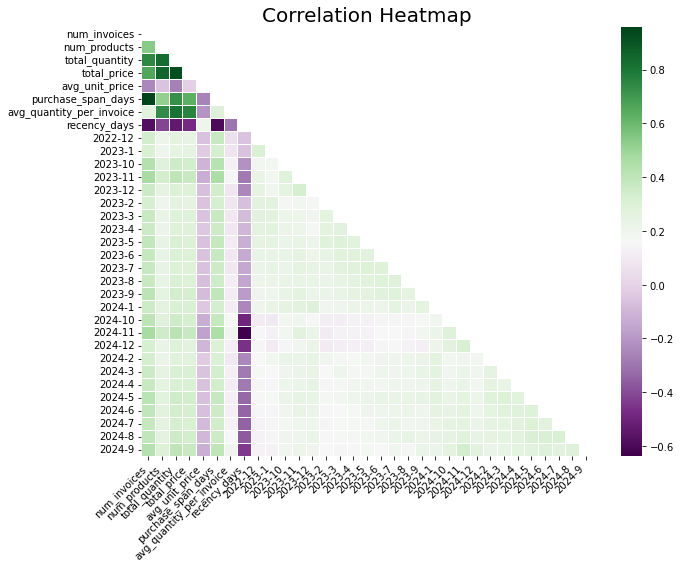

In [0]:
# Define the list of metric features
new_metric_features = ['num_invoices','num_products','total_quantity','total_price','avg_unit_price','purchase_span_days','avg_quantity_per_invoice','recency_days','2022-12','2023-1','2023-10','2023-11','2023-12','2023-2','2023-3','2023-4','2023-5','2023-6','2023-7','2023-8','2023-9','2024-1','2024-10','2024-11','2024-12','2024-2','2024-3','2024-4','2024-5','2024-6','2024-7','2024-8','2024-9']  

# VectorAssembler is a Spark ML tool that combines multiple columns into a single vector column
assembler = VectorAssembler(inputCols=new_metric_features, outputCol="features_vector")
df_vector = assembler.transform(df_clustering).select("features_vector") # Output

# Compute Spearman correlation matrix
correlation_result = Correlation.corr(df_vector, "features_vector", method="spearman").head()
corr_matrix = correlation_result[0].toArray() # toArray() converts Spark's matrix to a NumPy array

# Convert Spark correlation matrix to Pandas DataFrame
corr_df = pd.DataFrame(corr_matrix, index=new_metric_features, columns=new_metric_features)

# Create a mask to hide the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr_df, dtype=bool))

# Plot heatmap using Seaborn & Matplotlib
plt.figure(figsize=(10, 8))
sns.heatmap(data=corr_df, mask=mask, annot=False, cmap='PRGn', cbar=True, square=False, linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Display the plot in Databricks
plt.show()


We are going to check the features highly correlated with threshold |0.8|.

In [0]:
# Extract pairs with strong correlations (|correlation| > 0.8)
strong_corr_pairs = []

for i, j in combinations(range(len(new_metric_features)), 2):
    corr_value = corr_df.iloc[i, j]
    if abs(corr_value) > 0.8:
        strong_corr_pairs.append((new_metric_features[i], new_metric_features[j], corr_value))

# Create a Pandas DataFrame from the results
strong_corr_df = pd.DataFrame(strong_corr_pairs, columns=["Feature 1", "Feature 2", "Correlation"])

# Sort by absolute correlation descending
strong_corr_df["AbsCorrelation"] = strong_corr_df["Correlation"].abs()
strong_corr_df.sort_values(by="AbsCorrelation", ascending=False, inplace=True)
strong_corr_df.drop(columns="AbsCorrelation", inplace=True)

# Display the result in Databricks
display(strong_corr_df)

Feature 1 Feature 2 Correlation num_invoices purchase_span_days 0.9573801878547392 total_quantity total_price 0.9223927527958522 num_products total_price 0.8523866314539023 num_products total_quantity 0.8274046161703706 total_quantity avg_quantity_per_invoice 0.811560111828839

From the analysis above, we decided to drop 2 features: *purchase_span_days* and *total_quantity*<br>
Moreover, we exclude time base features (e.g., 2022-12) for clustering. We will used them for profiling.

In [0]:
vb_features = ["Customer ID", "num_products", "num_invoices", "total_price", "avg_unit_price", "recency_days", "avg_quantity_per_invoice"]

df_vb = df_clustering.select(*vb_features)
df_vb.limit(10).display()

Customer ID num_products num_invoices total_price avg_unit_price recency_days avg_quantity_per_invoice 13285 182 6 3364.59 2.33 23 409.5 14570 64 3 613.75 3.29 280 143.67 15846 27 1 107.01 1.82 386 79.0 25462 158 1 1281.03 6.11 199 278.0 17420 43 8 943.68 3.41 50 55.5 24171 13 1 43.25 2.49 266 22.0 16386 127 3 1068.16 2.05 28 233.33 18024 21 3 236.78 2.66 152 49.33 15727 426 15 9371.71 3.57 16 393.87 16339 17 1 94.05 4.96 285 21.0

### 2.2. Clustering Using K-MEANS

We are going to use K-Means algorithm for clustering. <br>
We are going to used MinMaxScaler to Scale the data since our data is not normally distributed. MinMaxScaler is useful when we want to ensure that all features have similar scales and are constrained within a certain range. This can improve the performance of algorithms that are sensitive to the scale of input features, such as gradient-based optimization algorithms.

In [0]:
# Start Spark session
spark = SparkSession.builder.appName("CustomerClustering").getOrCreate()

# Assemble all features into a single vector
# Exclude 'clientID' from the list of features
feature_cols = [col for col in df_vb.columns if col != "Customer ID"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_unscaled")
assembled = assembler.transform(df_vb)

# Scale features using MinMaxScaler
scaler = MinMaxScaler(inputCol="features_unscaled", outputCol="features")
scaler_model = scaler.fit(assembled)
scaled_data = scaler_model.transform(assembled)

We are going to check how many clusters are best for our data by using elbow method.

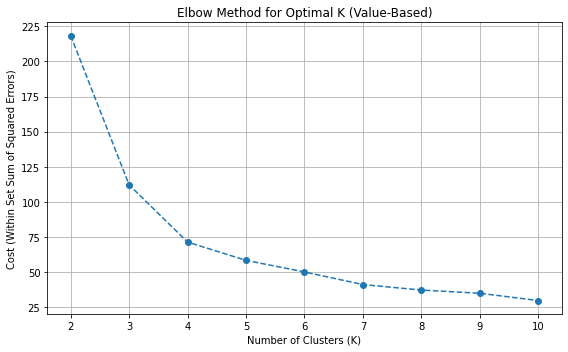

In [0]:
cost = []
k_values = list(range(2, 11))

for k in k_values:
    kmeans = KMeans(featuresCol="features", k=k, seed=42)
    model = kmeans.fit(scaled_data)
    cost.append(model.summary.trainingCost)

# Plot the elbow curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(k_values, cost, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Cost (Within Set Sum of Squared Errors)")
plt.title("Elbow Method for Optimal K (Value-Based)")
plt.grid(True)
plt.tight_layout()
plt.show()

From the plot above, we are going to use K=3.

In [0]:
# Create clusters with k=3
kmeans = KMeans(featuresCol="features", k=3, seed=1)  
model = kmeans.fit(scaled_data)
predictions = model.transform(scaled_data)

# Evaluate clustering
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette}")

Silhouette Score: 0.7685266695191887


In [0]:
# Show number of customers per cluster
predictions.groupBy("prediction").count().orderBy("prediction").show()


+----------+-----+
|prediction|count|
+----------+-----+
|         0| 2109|
|         1| 4524|
|         2| 2810|
+----------+-----+



In [0]:
display(predictions)

Customer ID num_products num_invoices total_price avg_unit_price recency_days avg_quantity_per_invoice features_unscaled features prediction 13285 182 6 3364.59 2.33 23 409.5 Map(vectorType -> dense, length -> 6, values -> List(182.0, 6.0, 3364.59, 2.33, 23.0, 409.5)) Map(vectorType -> dense, length -> 6, values -> List(0.07081377151799687, 0.009823182711198428, 0.09128403019114693, 0.6809781279441259, 0.031123139377537214, 0.011445728219502746)) 1 14570 64 3 613.75 3.29 280 143.67 Map(vectorType -> dense, length -> 6, values -> List(64.0, 3.0, 613.75, 3.29, 280.0, 143.67)) Map(vectorType -> dense, length -> 6, values -> List(0.024647887323943664, 0.003929273084479371, 0.08687545591772695, 0.6809903253205465, 0.3788903924221922, 0.008416740730612337)) 2 15846 27 1 107.01 1.82 386 79.0 Map(vectorType -> dense, length -> 6, values -> List(27.0, 1.0, 107.01, 1.82, 386.0, 79.0)) Map(vectorType -> dense, length -> 6, values -> List(0.010172143974960877, 0.0, 0.08606334000865452, 0.6809716480879024, 0.5223274695534507, 0.007679861443449329)) 2 25462 158 1 1281.03 6.11 199 278.0 Map(vectorType -> dense, length -> 6, values -> List(158.0, 1.0, 1281.03, 6.11, 199.0, 278.0)) Map(vectorType -> dense, length -> 6, values -> List(0.06142410015649452, 0.0, 0.0879448577881257, 0.6810261551137818, 0.2692828146143437, 0.009947357626307513)) 1 17420 43 8 943.68 3.41 50 55.5 Map(vectorType -> dense, length -> 6, values -> List(43.0, 8.0, 943.68, 3.41, 50.0, 55.5)) Map(vectorType -> dense, length -> 6, values -> List(0.01643192488262911, 0.013752455795677798, 0.08740421110160877, 0.6809918499925991, 0.06765899864682003, 0.0074120917937148196)) 1 24171 13 1 43.25 2.49 266 22.0 Map(vectorType -> dense, length -> 6, values -> List(13.0, 1.0, 43.25, 2.49, 266.0, 22.0)) Map(vectorType -> dense, length -> 6, values -> List(0.004694835680751174, 0.0, 0.08596115642266869, 0.680980160840196, 0.3599458728010826, 0.007030377612178391)) 2 16386 127 3 1068.16 2.05 28 233.33 Map(vectorType -> dense, length -> 6, values -> List(127.0, 3.0, 1068.16, 2.05, 28.0, 233.33)) Map(vectorType -> dense, length -> 6, values -> List(0.04929577464788733, 0.003929273084479371, 0.0876037062832825, 0.6809745703760033, 0.037889039242219216, 0.009438367402748343)) 1 18024 21 3 236.78 2.66 152 49.33 Map(vectorType -> dense, length -> 6, values -> List(21.0, 3.0, 236.78, 2.66, 152.0, 49.33)) Map(vectorType -> dense, length -> 6, values -> List(0.00782472613458529, 0.003929273084479371, 0.08627131309449801, 0.6809823207922705, 0.2056833558863329, 0.0073417880175930365)) 1 15727 426 15 9371.71 3.57 16 393.87 Map(vectorType -> dense, length -> 6, values -> List(426.0, 15.0, 9371.71, 3.57, 16.0, 393.87)) Map(vectorType -> dense, length -> 6, values -> List(0.16627543035993742, 0.027504911591355596, 0.1009112112301556, 0.6809938828886691, 0.02165087956698241, 0.011267632916296347)) 1 16339 17 1 94.05 4.96 285 21.0 Map(vectorType -> dense, length -> 6, values -> List(17.0, 1.0, 94.05, 4.96, 285.0, 21.0)) Map(vectorType -> dense, length -> 6, values -> List(0.006259780907668232, 0.0, 0.08604256994475276, 0.6810115436732781, 0.3856562922868742, 0.0070189831589981995)) 2 14450 47 7 1128.44 2.95 180 74.57 Map(vectorType -> dense, length -> 6, values -> List(47.0, 7.0, 1128.44, 2.95, 180.0, 74.57)) Map(vectorType -> dense, length -> 6, values -> List(0.017996870109546165, 0.011787819253438112, 0.08770031272247988, 0.6809860054163974, 0.2435723951285521, 0.007629384015861078)) 1 15957 121 3 921.25 2.44 31 151.0 Map(vectorType -> dense, length -> 6, values -> List(121.0, 3.0, 921.25, 2.44, 31.0, 151.0)) Map(vectorType -> dense, length -> 6, values -> List(0.046948356807511735, 0.003929273084479371, 0.08736826414687757, 0.6809795255601742, 0.04194857916102842, 0.008500262072423144)) 1 26425 172 1 1121.46 4.87 79 290.0 Map(vectorType -> dense, length -> 6, values -> List(172.0, 1.0, 1121.46, 4.87, 79.0, 290.0)) Map(vectorType -> dense, length -> 6, values -> List(0.06690140845070423, 0.0, 0.0876

In [0]:
# Select only 'Customer ID' and 'prediction' from predictions
predictions_selected = predictions.select("Customer ID", "prediction")

# Perform the left join
df_final = df_clustering.join(predictions_selected, on="Customer ID", how="left")
df_final.limit(10).display()

Customer ID num_invoices num_products total_quantity total_price avg_unit_price first_purchase_date last_purchase_date purchase_span_days avg_quantity_per_invoice recency_days 2022-12 2023-1 2023-10 2023-11 2023-12 2023-2 2023-3 2023-4 2023-5 2023-6 2023-7 2023-8 2023-9 2024-1 2024-10 2024-11 2024-12 2024-2 2024-3 2024-4 2024-5 2024-6 2024-7 2024-8 2024-9 prediction 13285 6 182 2457 3364.59 2.33 2023-03-25 2024-11-16 602 409.5 23 0 0 0 0 0 0 21 23 0 0 0 0 0 0 0 50 0 52 0 30 0 0 55 0 0 1 14570 3 64 431 613.75 3.29 2023-09-22 2024-03-04 164 143.67 280 0 0 0 0 0 0 0 0 0 0 0 0 39 0 0 0 0 0 29 0 0 0 0 0 0 2 15846 1 27 79 107.01 1.82 2023-11-19 2023-11-19 0 79.0 386 0 0 0 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 25462 1 158 278 1281.03 6.11 2024-05-24 2024-05-24 0 278.0 199 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 158 0 0 0 0 1 17420 8 43 444 943.68 3.41 2023-11-03 2024-10-20 352 55.5 50 0 0 0 22 7 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 14 0 0 0 1 24171 1 13 22 43.25 2.49 2024-03-18 2024-03-18 0 22.0 266 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 13 0 0 0 0 0 0 2 16386 3 127 700 1068.16 2.05 2023-11-17 2024-11-11 360 233.33 28 0 0 0 58 0 0 0 0 0 0 0 0 0 0 0 77 0 0 4 0 0 0 0 0 0 1 18024 3 21 148 236.78 2.66 2024-07-10 2024-07-10 0 49.33 152 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 22 0 0 1 15727 15 426 5908 9371.71 3.57 2023-01-24 2024-11-23 669 393.87 16 0 99 0 50 66 0 0 0 87 13 116 19 0 32 0 39 0 0 0 46 14 0 30 74 0 1 16339 1 17 21 94.05 4.96 2024-02-28 2024-02-28 0 21.0 285 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 18 0 0 0 0 0 0 0 2

# 3. Export CVS File

In [0]:
df_pandas = df_final.toPandas()

In [0]:
df_pandas.to_csv("/tmp/df_final.csv", index=False)

In [0]:
dbutils.fs.cp("file:/tmp/df_final.csv", "dbfs:/FileStore/df_final.csv")

Out[15]: True

# 4. Profiling

Now, we are going to profile each customer clusters.

## 4.1. Time Base Profiling 

In [0]:
profiling_time = ['2022-12','2023-1','2023-10','2023-11','2023-12','2023-2','2023-3','2023-4','2023-5','2023-6','2023-7','2023-8','2023-9','2024-1','2024-10','2024-11','2024-12','2024-2','2024-3','2024-4','2024-5','2024-6','2024-7','2024-8','2024-9']

In [0]:
# Group by 'prediction' and sum selected columns
agg_exprs = [F.sum(col).alias(col) for col in profiling_time]

df_time_cluster = df_final.groupBy('prediction').agg(*agg_exprs)
df_time_cluster.limit(10).display()

prediction 2022-12 2023-1 2023-10 2023-11 2023-12 2023-2 2023-3 2023-4 2023-5 2023-6 2023-7 2023-8 2023-9 2024-1 2024-10 2024-11 2024-12 2024-2 2024-3 2024-4 2024-5 2024-6 2024-7 2024-8 2024-9 1 23171 16220 37666 48535 22152 17404 24329 20556 22950 25001 21486 21261 28366 18552 59731 83077 25193 17492 24414 20394 30960 36425 39078 34933 49699 2 4828 3904 20321 27690 19558 3811 5073 4133 3895 4121 4045 6573 13070 16208 0 0 0 9860 11779 9045 5578 0 0 0 0 0 16462 10873 0 0 0 7306 11279 8793 7519 10059 7316 4846 0 0 0 0 0 0 0 0 0 0 0 0 0

### Plot using Pandas

In [0]:
# Make a function
def plot_profiling_barplots_spark(df, merged_labels_col, features):
    # Aggregate in Spark
    # For each feature, sum the values grouped by the target label
    agg_exprs = [F.sum(col).alias(col) for col in features]
    grouped_pre_df = df.groupBy(merged_labels_col).agg(*agg_exprs)
    
    # Convert to Pandas
    grouped_df = grouped_pre_df.toPandas()
    
    # Plot using the same logic as before
    sns.set_style('white')
    
    # ensure the label column is in string format for consistent plotting
    if grouped_df[merged_labels_col].dtype == 'category' or not pd.api.types.is_numeric_dtype(grouped_df[merged_labels_col]):
        grouped_df[merged_labels_col] = grouped_df[merged_labels_col].astype(str)

    # Convert feature columns to numeric if necessary
    for feature in features:
        if not pd.api.types.is_numeric_dtype(grouped_df[feature]):
            grouped_df[feature] = pd.to_numeric(grouped_df[feature], errors='coerce')

    # Determine layout
    n_features = len(features)
    n_cols = 4
    n_rows = (n_features // n_cols) + (n_features % n_cols > 0)

    # Create subplot grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
    axes = axes.flatten()

    # Create bar plots for each feature
    for i, feature in enumerate(features):
        sns.barplot(x=merged_labels_col, y=feature, data=grouped_df, color='darkgreen', ax=axes[i])
        axes[i].set_title(f'{feature} by {merged_labels_col}')
        axes[i].set_xlabel(merged_labels_col)
        axes[i].set_ylabel('Counts')
        axes[i].tick_params(axis='x', rotation=90)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

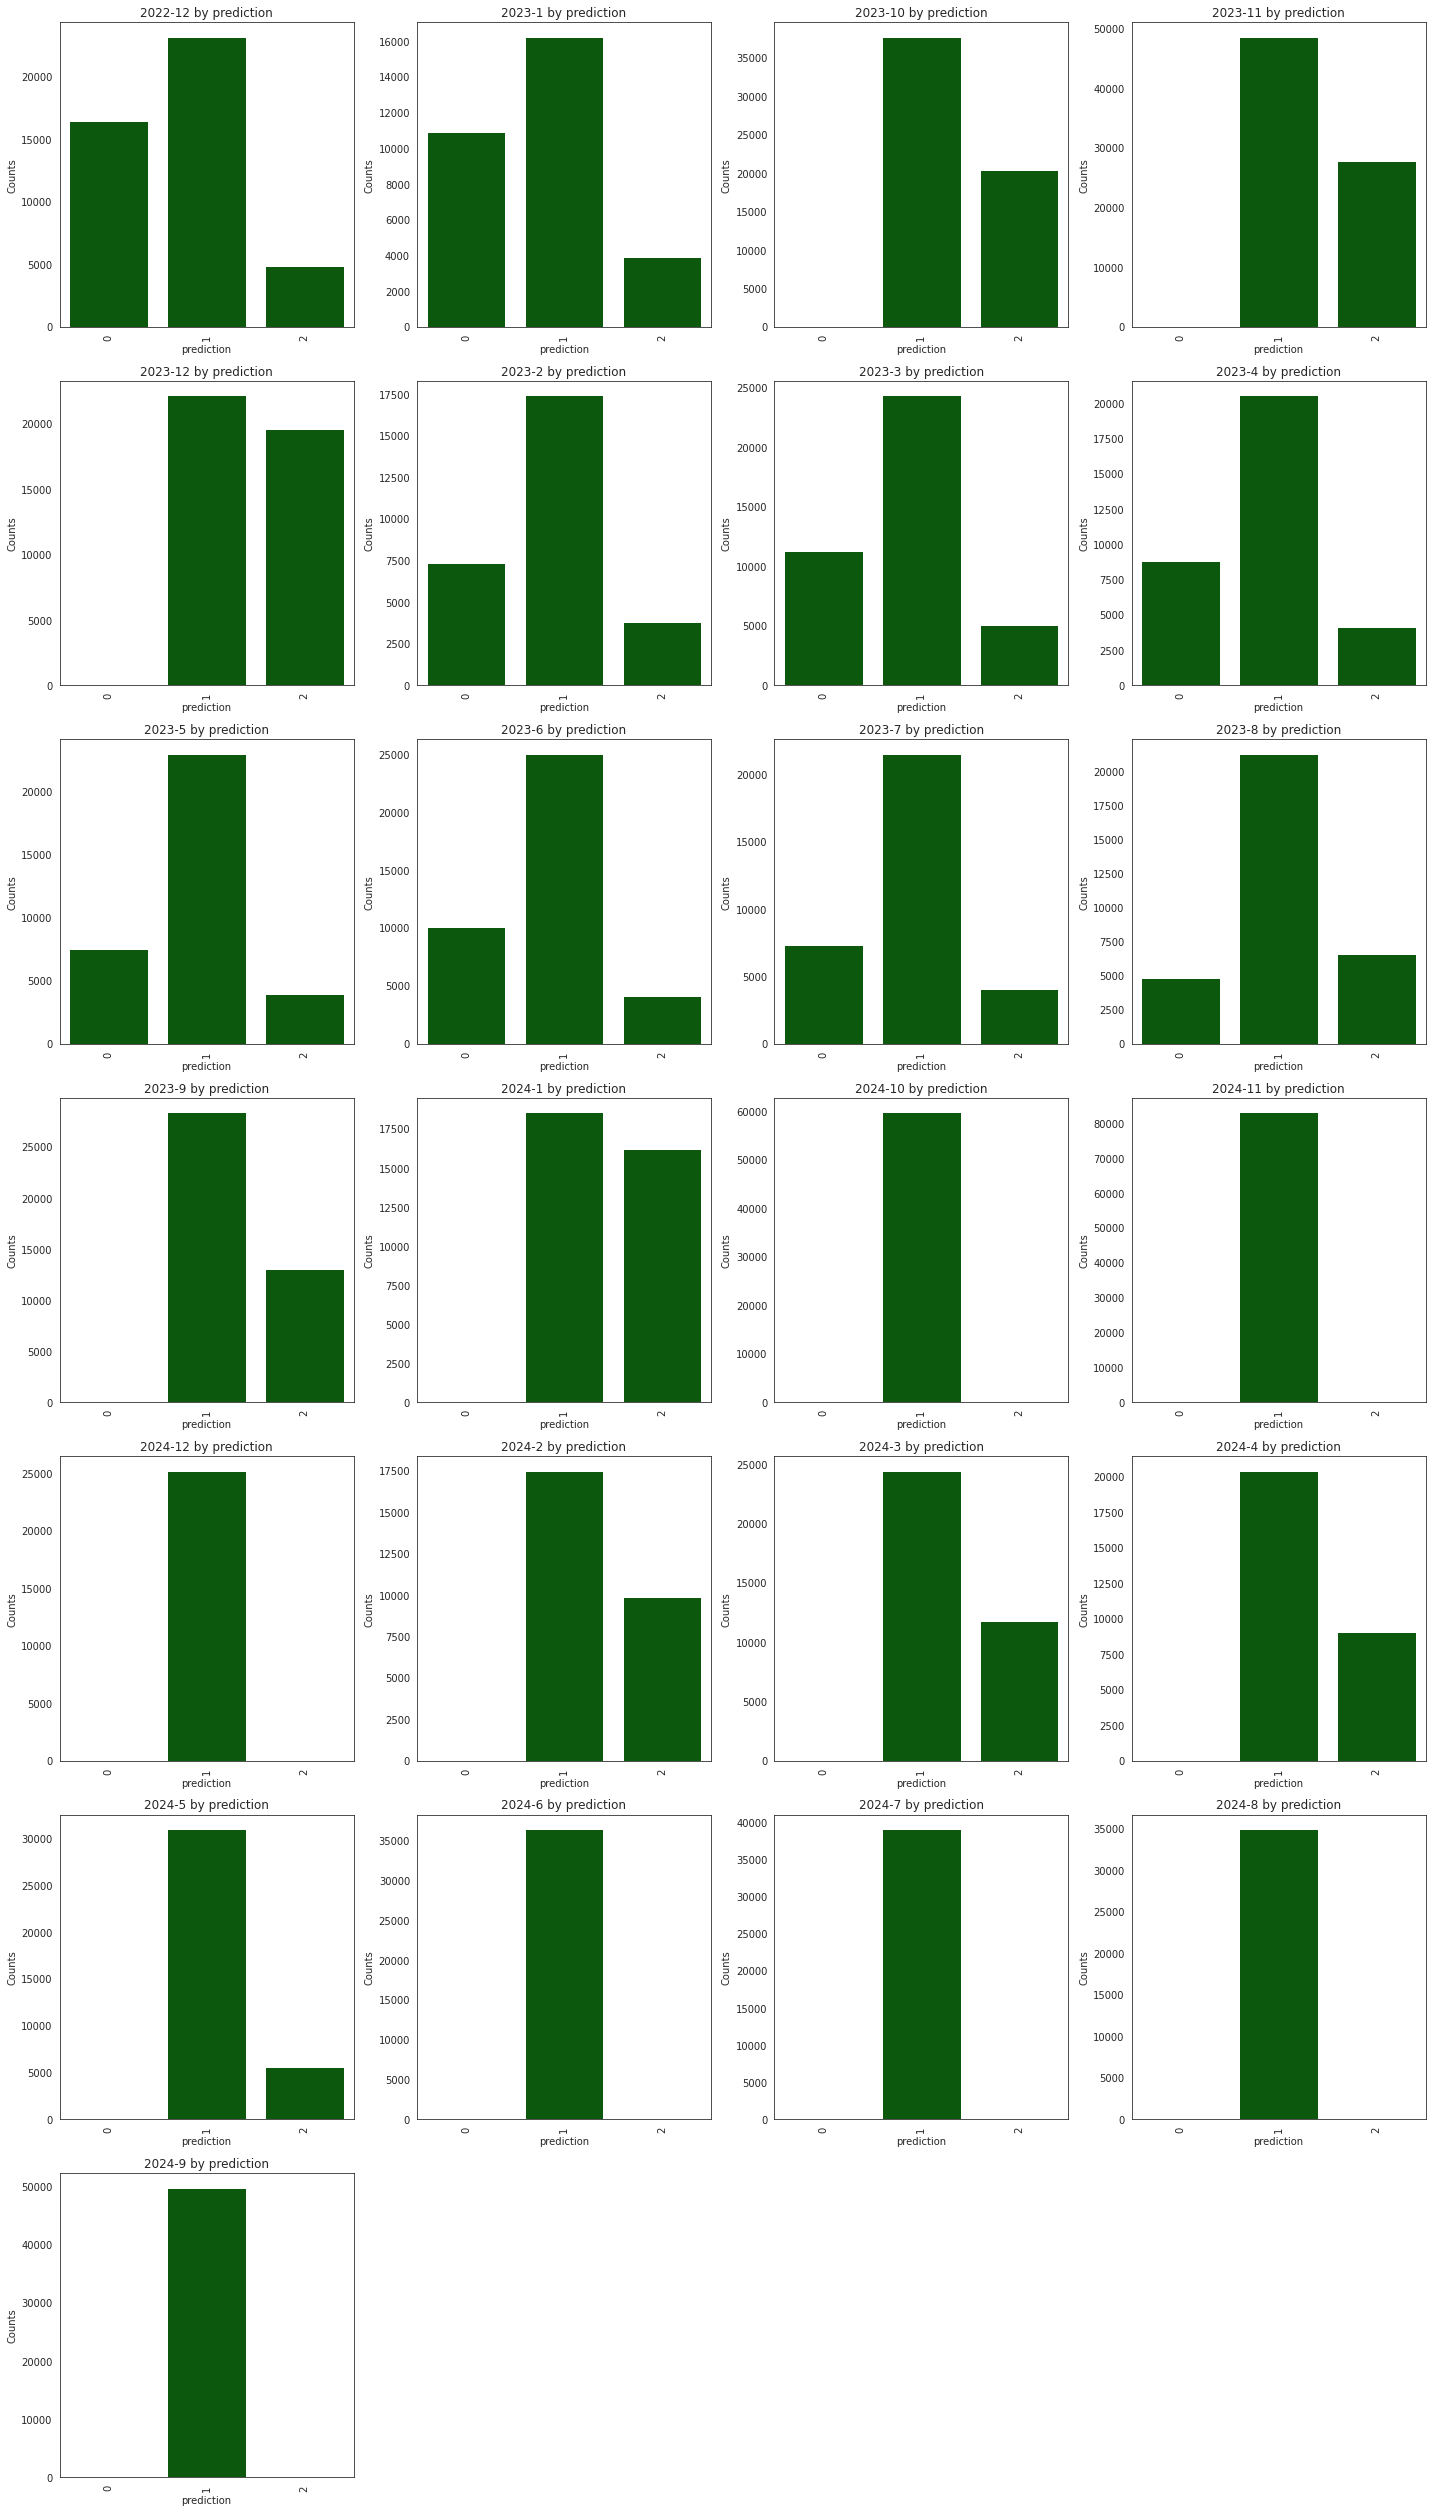

In [0]:
# Show the plot
plot_profiling_barplots_spark(df_final, 'prediction', profiling_time)

## 4.2. Behavior Base Profiling

In [0]:
profiling_metric = ['num_invoices','num_products','total_quantity','total_price','avg_unit_price','purchase_span_days','avg_quantity_per_invoice','recency_days']

In [0]:
# Create aggregation expressions to sum each selected profiling metric
# This generates a list of expressions like: F.sum('metric1').alias('metric1'), ...
agg_exprs = [F.sum(col).alias(col) for col in profiling_metric]

# Group the final DataFrame by the predicted cluster label
# Then, aggregate each profiling metric by summing its values within each cluster
df_metric_cluster = df_final.groupBy('prediction').agg(*agg_exprs)

In [0]:
display(df_metric_cluster)

prediction num_invoices num_products total_quantity total_price avg_unit_price purchase_span_days avg_quantity_per_invoice recency_days 1 39069 475495 8944737 1.5474232199999986E7 167653.08000000002 1409633 973365.2699999984 287419 2 6477 154232 1192695 2411350.140000006 272265.75000000093 207534 598301.65 989443 0 2814 81802 590838 969747.8399999992 125746.3200000001 23907 304585.22000000003 1274306

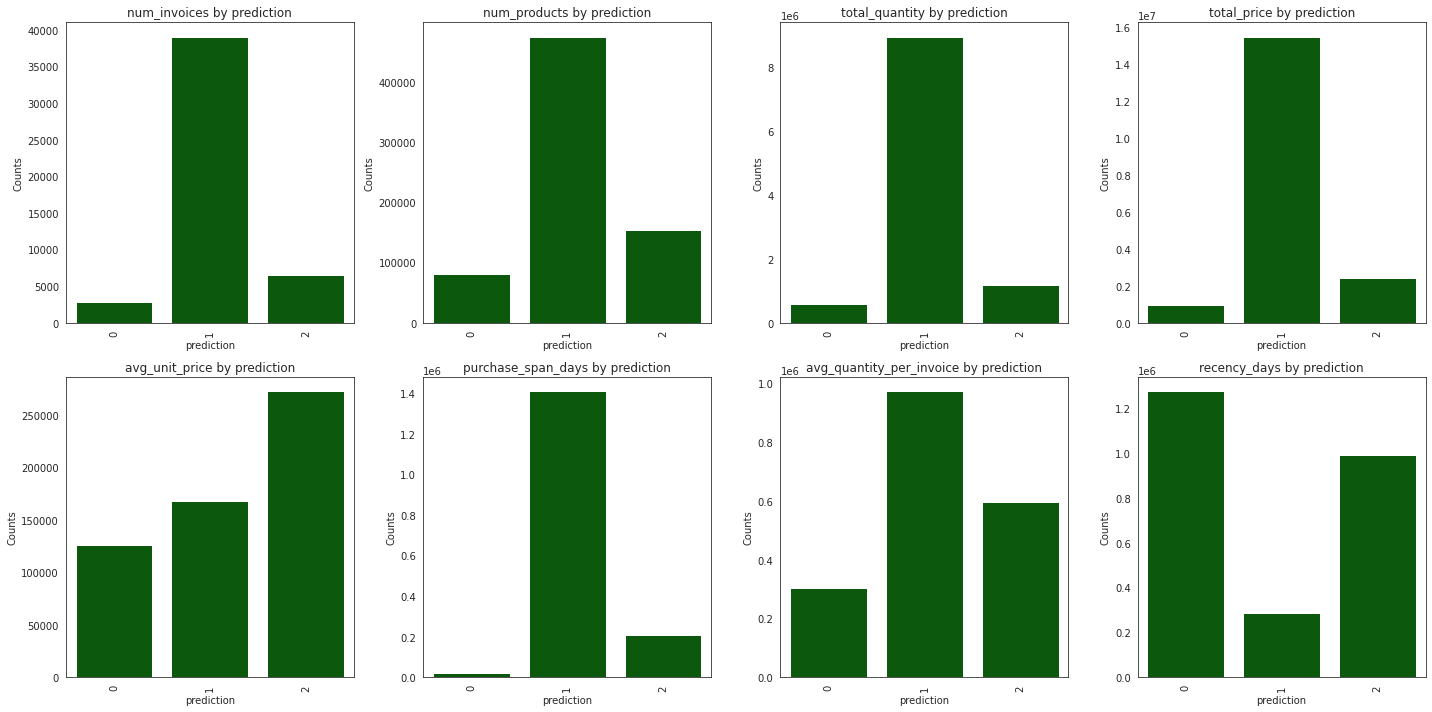

In [0]:
# Call the custom function to generate barplots for profiling metrics per cluster

# Parameters:
# - df_final: The Spark DataFrame containing the final data with predictions
# - 'prediction': The name of the column used for grouping (typically cluster labels)
# - profiling_metric: A list of feature names (columns) to sum and visualize per group

# Show the plot
plot_profiling_barplots_spark(df_final, 'prediction', profiling_metric)

## 4.3. Customer Profiling


### **Cluster 0: Inactive or Lost Customers**
#### Size: 2,109 customers
##### Key Characteristics:
- Lowest in invoices, products, quantity, revenue, and average unit price.
- Very long recency – they haven’t purchased in a long time.
- Short customer lifetime (Purchase Span Days).
- Lowest average quantity per invoice.
- Most recent purchases occurred mainly in 2022-2023 summer. 
- No purchases at all in late 2023 or 2024.

##### Profile Summary:
These are inactive or churned customers. They used to engage at a low level but have now completely stopped purchasing. This group may have switched to competitors, closed their business, or found less value in our offerings.

##### Actionable Strategy:
- Restart Campaigns: Special reactivation offers or targeted email campaigns.
- Feedback collection: Try to learn why they stopped ordering.
- Consider removing them from active targeting if unresponsive after multiple campaigns.

### **Cluster 1: High-Value Loyal Customers**
#### Size: 4,524 customers

##### Key Characteristics:
- Highest across all transactional metrics: invoices, products, quantity, revenue.
- Consistent across all months and years, highly active and reliable.
- Frequent purchases with large average quantities per invoice.
- Recent and ongoing engagement.
- Long customer lifetime (long span days).

##### Profile Summary:
These customers are our top-tier wholesale customers who are loyal, high-frequency, and high-value buyers. They show strong ongoing engagement and form the backbone of our business.

##### Actionable Strategy:
- Loyalty Programs: Reward frequent buyers such as discounts, early access, bulk deals.
- Develop recommendation system: Tailor product recommendations.

### **Cluster 2: Occasional or Premium Buyers**
#### Size: 2,810 customers

##### Key Characteristics:
- Middle in invoice count, product variety, quantity, and revenue.
- Highest average unit price which means they buy fewer, but more expensive items.
- Somewhat consistent but limited engagement through 2023 and early 2024, disappeared the middle of 2024.
- Moderate recency tells that they are not fully inactive, but not as recent as Cluster 1.
- Average quantity per invoice is moderate.

##### Profile Summary:
These are likely small boutique resellers or premium buyers. Occasional purchases, preference for luxury and selected gift items, and small, high-margin orders. Their pattern shows selective engagement.

##### Actionable Strategy:
- Premium Product Bundles: Offer curated or seasonal premium boxes.
- Targeted product launches (high-margin or exclusive items).
-  Encourage regular use with small loyalty rewards or “limited time” offers.

| Cluster | Size  | Activity Level | Customer Type | Recency | Spending | Strategy |
|---------|-------|----------------|---------------|---------|----------|----------|
| 0 | 2,109 | Inactive | Churned/Lost | High | Low | Restart Campaign, survey |
| 1 | 4,524 | Active | High-value/Loyal | Low | High | Loyalty, upsell |
| 2 | 2,810 | Moderate | Occasional/Premium | Medium | Medium | Premium-focused |